# Importing Librarires

In [4]:
import pandas as pd
import os
import shutil

## Arragnging all the images in 7 sub folders under a Universal folder Reorganized.

In [6]:
data_dir=os.getcwd()+"/Dataset/all_images"
dest_dir=os.getcwd()+"/Dataset/Reorganized/"
# Read the csv file containing image names and corresponding labels
skin_df=pd.read_csv('Dataset/HAM10000_metadata.csv')
print(skin_df['dx'].value_counts())
label=skin_df['dx'].unique().tolist()
label_images=[]
for i in label:
    os.mkdir(dest_dir + str(i) + "/")
    sample = skin_df[skin_df['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]    

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


## Processing the Images in each sub folder.

In [8]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
from matplotlib import pyplot as plt
datagen = ImageDataGenerator()
train_dir = os.getcwd() + "/Dataset/Reorganized/"
train_data_keras = datagen.flow_from_directory(directory=train_dir,
                                         class_mode='categorical',
                                         batch_size=16, 
                                         target_size=(32,32))

Found 10015 images belonging to 7 classes.


# Plotting the Images.

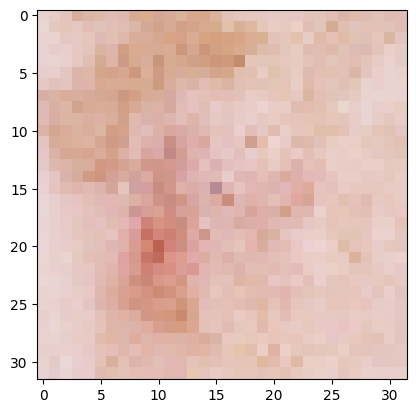

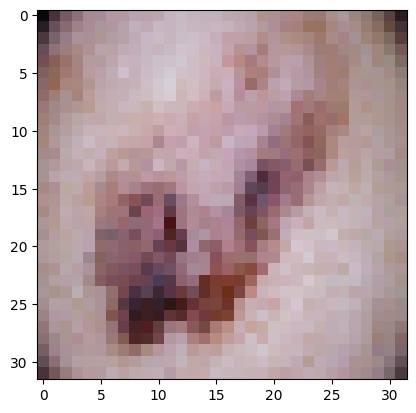

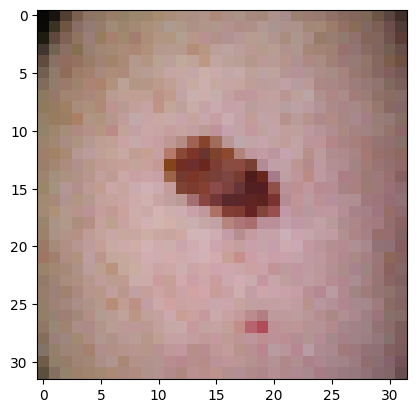

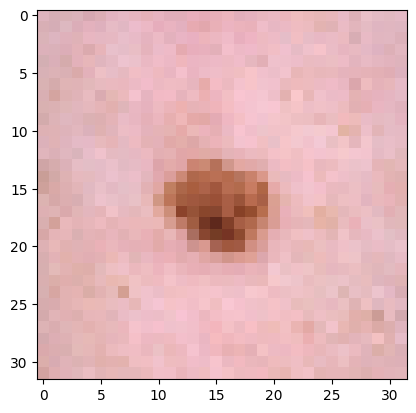

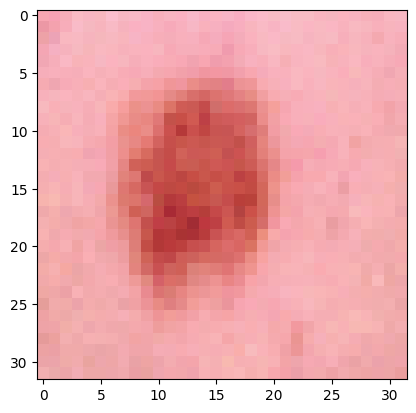

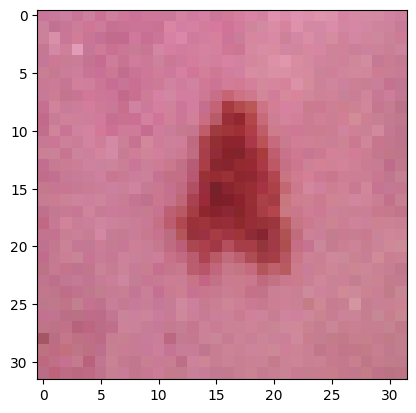

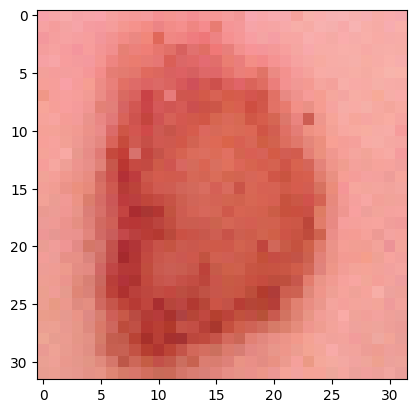

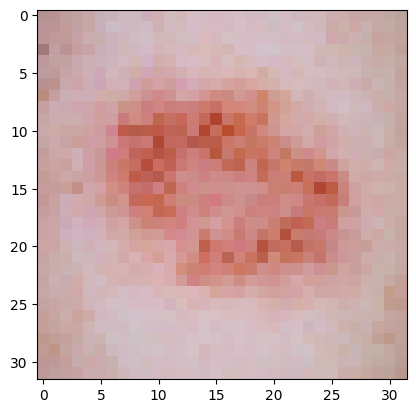

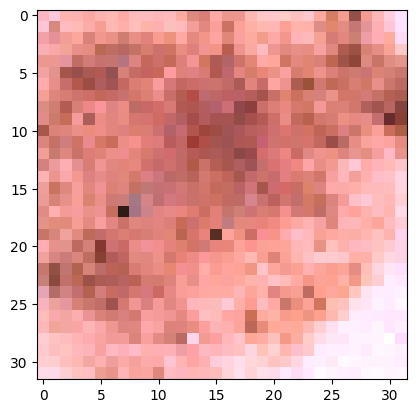

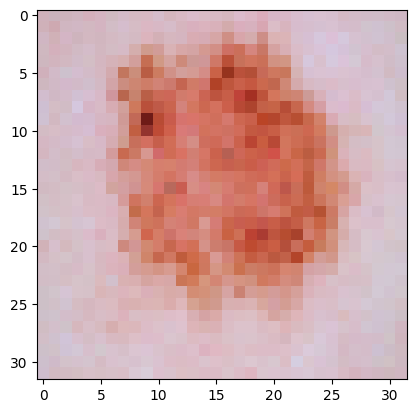

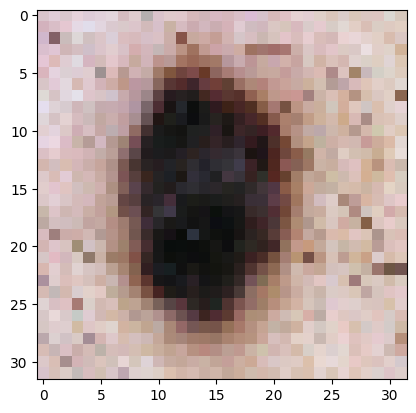

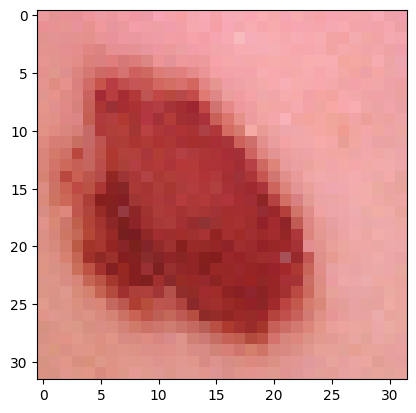

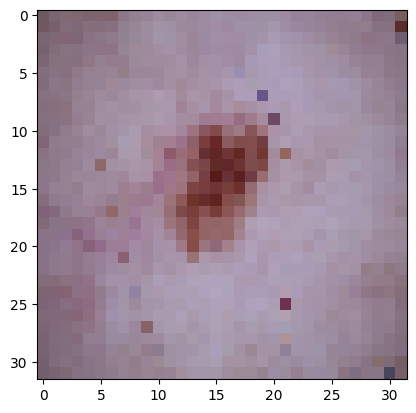

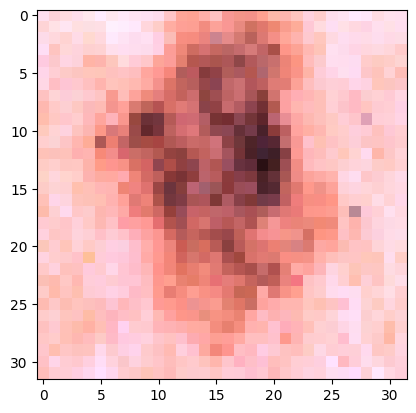

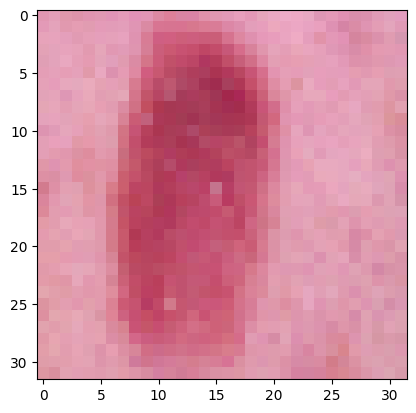

In [9]:
x, y = next(train_data_keras)
for i in range (0,15):
    image = x[i].astype(int)
    plt.imshow(image)
    plt.show()

# Importing the Libraries